In [ ]:
!pip install pandas --upgrade
!pip install openpyxl --upgrade 
!pip install fastprogress
!pip install networkx
!pip install graphviz
!pip install astprogress

In [2]:
import networkx as nx
import numpy as np 
import pandas as pd
import graphviz
from fastprogress import master_bar, progress_bar
from tabulate import tabulate
import random
import matplotlib.pyplot as plt

Original link for dataset: https://datadryad.org/stash/dataset/doi:10.5061/dryad.hj1t4

##DATA EXPLORATION

In [3]:
data = pd.read_excel('l4n_dataset/OD_DB_Med2005.xlsx')

###About the dataset
 
It represents a directed multiplex multigraph composed of 413 nodes and 128635
edges. Each node represents an urban zone of Medellín city (Colombia), whereas
each edge represents a travel between two urban zones. There are 6 layers in this
network, each one representing a different socioeconomic group. Each edge is also
labelled with some additional information such as departure and arrival times, mean
travel time and the purpose of each trip (work, school, entertainment etc).

In the following each row of the table represents a specific edge (trip). 


**Legend:**
 
  **ORIG**: id of starting node (urban zone) of the trip (from 1 to 413)

  **DEST**: id of destination node (urban zone) of the trip (from 1 to 413)
  
  **EST**: indicates the "estrato" or socioeconomic class/status of the household of the traveler (1 the lowest income householders and 6 the richest)

  **HSAL**: indicates the departure hour (decimal) of the trip
  
  **HLLEG**: indicates the arrival hour (decimal) of the trip
  
  **MOT**: indicates the purpose of trip (1 work, 2 study, 3 shopping, 4 health, 5 recreation, 6 return home, 7 others)
  
  **HMV**: describes the mean hour of trip (mean of the previous 2 values) 
  
  **FEV**: is the expansion factor of the survey



In [4]:
# This add the column with the travel time (travel duration), correcting for trips around midnight with %24
data['TIME'] = (data['HLLEG'] - data['HSAL'])%24    

# Show some row of the dataset. One row is one trip
data.head()  

,ORIG,DEST,EST,HSAL,HLLEG,MOT,HMV,FEV,TIME
0,285,413,3,6.5,10.250000,7,8.375000,10.811000,3.750000
1,289,410,2,15.0,18.666667,7,16.833333,6.011859,3.666667
2,135,411,4,4.5,8.000000,1,6.250000,57.167647,3.500000
3,321,413,3,5.5,9.000000,7,7.250000,8.115140,3.500000
4,151,410,4,6.0,9.500000,7,7.750000,56.850000,3.500000


### Function: multi_edge_merge(est)
**multi_edge_merge(est)**: function to merge together the edges that connect the same 2 nodes, operates on a single economic class "est" given in input. The function also adds the following attributes:

*  weight = normalized sum of all expansion factors of the merged edges ( = estimated fraction of people of the given class that performed that trip, considering the expansion factor)
*  weight_inv = inverse of weight
*  time = mean of the travel time of the merged edges
*  count = number of edge merged for that particular trip ( = number of interviewed people that performed that trip)


In [5]:
def multi_edge_merge(data, est): 
  sum = data.loc[data['EST'] == est]['FEV'].sum()
  df = data.loc[data['EST'] == est].groupby(['ORIG', 'DEST']).agg(weight=('FEV', lambda x: np.sum(x)/sum), weight_inv=('FEV', lambda x: sum/np.sum(x)), time=('TIME', lambda x: np.mean(x)), count=pd.NamedAgg(column='DEST', aggfunc="count"), weight_nn=('FEV', lambda x: np.sum(x))).reset_index()
  G = nx.DiGraph()
  edges = [[df.iloc[i, 0], df.iloc[i, 1], {'weight' : df.iloc[i, 2], 'weight_inv' : df.iloc[i,3], 'time' : df.iloc[i,4], 'count' : df.iloc[i,5], 'weight_nn' : df.iloc[i,6]}] for i in range(0,len(df))]
  G.add_edges_from(edges)
  return G


#### Creation of vector G
one component of G is the simple graph associated to an economic class

In [6]:
#creates a vector of graph, one for each economic class

G = [multi_edge_merge(data, i) for i in range(1,7)]
for g in G:
  print(tabulate((list(g.edges(data=True))[0:5]), headers=['ORIG', 'DEST', 'Attributes']),'\n\n')

  ORIG    DEST  Attributes
------  ------  ----------------------------------------------------------------------------------------------------------------------------------------------
     1       1  {'weight': 0.0002980732676981987, 'weight_inv': 3354.8798512602852, 'time': 1.25, 'count': 2, 'weight_nn': 88.70123751745452}
     1       5  {'weight': 0.00013605131844988798, 'weight_inv': 7350.167652864987, 'time': 0.25, 'count': 1, 'weight_nn': 40.48642270263971}
     1       9  {'weight': 0.00040815395534966393, 'weight_inv': 2450.0558842883293, 'time': 0.30555555555555536, 'count': 3, 'weight_nn': 121.45926810791912}
     1      29  {'weight': 4.592571767754391e-05, 'weight_inv': 21774.29228262154, 'time': 0.25, 'count': 1, 'weight_nn': 13.666666666666666}
     1      30  {'weight': 0.00013605131844988798, 'weight_inv': 7350.167652864987, 'time': 0.25, 'count': 1, 'weight_nn': 40.48642270263971} 


  ORIG    DEST  Attributes
------  ------  -----------------------------------------

##GRAPH ANALYSIS

###Degree of mobility: in-degree and out-degree

Compute in-degree, out-degree and total degree for each node of each graph (=each social class)
The in-degree is useful because it allows to understand for each social class which are the most visited nodes/urban zone. 
The out-degree allows to understand for each social class which are the places from which the most trips depart. 

Notice: the original dataset could have multiple edges beetween the same couple of nodes (each edge was corresponding to a single trip that differs from the others for the starting hour and/or ending hour and/or motivation of the trip), we collapsed all these edges in a single edge taking the normalized sum of their FEV (expansion factor). 
In the calculation of the degrees we consider only those single edges. 
Therefore these statistics show the nodes that are more 'connected' to the others (not in the sense of number of trips but number of other locations) 





In [7]:
nodes_in_degrees_sorted = list()
nodes_out_degrees_sorted = list()
nodes_degrees_sorted = list()

#Compute out-degrees and in-degrees for each social class
for i in range(len(G)):
  nodes = G[i].nodes()
  nodes_in_degrees = {n:G[i].in_degree(n) for n in nodes}
  nodes_out_degrees = {n:G[i].out_degree(n) for n in nodes}
  nodes_degrees = {n:G[i].degree(n) for n in nodes}
  nodes_in_degrees_sorted.append(sorted(nodes_in_degrees.items(), key=lambda item: item[1], reverse=True))
  nodes_out_degrees_sorted.append(sorted(nodes_out_degrees.items(), key=lambda item: item[1], reverse=True))
  nodes_degrees_sorted.append(sorted(nodes_degrees.items(), key=lambda item: item[1], reverse=True))

  print('\n\nClass: ', i+1)
  print('Node  |  Degree ')
  j = 0
  for node, value in nodes_degrees_sorted[i]:
    j+=1 
    print(' {:3d}  |  {:.3f}'.format(node, value))
    if j >= 10:
      break




Class:  1
Node  |  Degree 
 189  |  154.000
 140  |  152.000
 259  |  149.000
   1  |  126.000
 188  |  126.000
 138  |  123.000
  48  |  90.000
 371  |  74.000
  10  |  71.000
  18  |  71.000


Class:  2
Node  |  Degree 
 339  |  424.000
   1  |  373.000
 337  |  316.000
 197  |  297.000
 287  |  274.000
   9  |  264.000
 283  |  264.000
  10  |  263.000
   6  |  252.000
 231  |  250.000


Class:  3
Node  |  Degree 
 337  |  351.000
   1  |  350.000
 231  |  310.000
   9  |  309.000
 339  |  305.000
 320  |  301.000
  10  |  289.000
 206  |  289.000
 285  |  288.000
 334  |  286.000


Class:  4
Node  |  Degree 
 261  |  199.000
 134  |  184.000
 113  |  182.000
 151  |  177.000
 158  |  152.000
 104  |  126.000
 162  |  126.000
 128  |  124.000
   1  |  122.000
 136  |  122.000


Class:  5
Node  |  Degree 
 121  |  153.000
 132  |  147.000
 126  |  143.000
 130  |  135.000
 131  |  132.000
 156  |  131.000
 310  |  127.000
 308  |  124.000
 119  |  122.000
 120  |  118.000


Class: 

###Strength of nodes

Similiar to nodes degrees but consider also the normalized averaged expansion factor (edges are weighted). This also consider the frequency of trips among the same couple of nodes

In [8]:
nodes_in_strengths_sorted = list()
nodes_out_strengths_sorted = list()
nodes_strengths_sorted = list()

#Compute out-degrees and in-degrees for each social class
for i in range(len(G)):
  nodes = G[i].nodes()
  nodes_in_strengths = {n:G[i].in_degree(n, weight='weight') for n in nodes}
  nodes_out_strengths = {n:G[i].out_degree(n, weight='weight') for n in nodes}
  nodes_strengths = {n:G[i].degree(n, weight='weight') for n in nodes}
  
  nodes_in_strengths_sorted.append(sorted(nodes_in_strengths.items(), key=lambda item: item[1], reverse=True))
  nodes_out_strengths_sorted.append(sorted(nodes_out_strengths.items(), key=lambda item: item[1], reverse=True))
  nodes_strengths_sorted.append(sorted(nodes_strengths.items(), key=lambda item: item[1], reverse=True))
  print('\n\nClass: ', i+1)
  print('Node  |  Strength')
  j = 0
  for node, value in nodes_strengths_sorted[i]:
    j+=1 
    print(' {:3d}  |  {:.3f}'.format(node, value))
    if j >= 10:
      break




Class:  1
Node  |  Strength
 259  |  0.161
 138  |  0.078
 188  |  0.068
 189  |  0.061
 140  |  0.059
   1  |  0.047
  48  |  0.046
  49  |  0.040
 139  |  0.040
 262  |  0.039


Class:  2
Node  |  Strength
 339  |  0.062
 256  |  0.059
 333  |  0.053
 197  |  0.032
   1  |  0.031
 315  |  0.030
 273  |  0.029
 334  |  0.027
 186  |  0.024
 269  |  0.023


Class:  3
Node  |  Strength
 334  |  0.040
   1  |  0.034
 206  |  0.032
 261  |  0.031
 196  |  0.030
 269  |  0.030
 330  |  0.030
 193  |  0.030
 256  |  0.029
 325  |  0.026


Class:  4
Node  |  Strength
  32  |  0.080
 113  |  0.063
 308  |  0.051
 151  |  0.050
  31  |  0.042
 104  |  0.042
 134  |  0.037
 312  |  0.034
 158  |  0.034
   1  |  0.033


Class:  5
Node  |  Strength
 130  |  0.092
 121  |  0.087
 126  |  0.070
 161  |  0.055
 123  |  0.052
 308  |  0.051
 120  |  0.051
 156  |  0.051
 132  |  0.049
 310  |  0.047


Class:  6
Node  |  Strength
  80  |  0.144
  95  |  0.128
  94  |  0.097
  93  |  0.089
  92  |  0

In [9]:
nodes_in_strengths_sorted_nn_weight = list()
nodes_out_strengths_sorted_nn_weight = list()
nodes_strengths_sorted_nn_weight = list()

#Compute out-degrees and in-degrees for each social class
for i in range(len(G)):
  nodes = G[i].nodes()
  nodes_in_strengths = {n:G[i].in_degree(n, weight='weight_nn') for n in nodes}
  nodes_out_strengths = {n:G[i].out_degree(n, weight='weight_nn') for n in nodes}
  nodes_strengths = {n:G[i].degree(n, weight= 'weight_nn') for n in nodes}
  
  nodes_in_strengths_sorted_nn_weight.append(sorted(nodes_in_strengths.items(), key=lambda item: item[1], reverse=True))
  nodes_out_strengths_sorted_nn_weight.append(sorted(nodes_out_strengths.items(), key=lambda item: item[1], reverse=True))
  nodes_strengths_sorted_nn_weight.append(sorted(nodes_strengths.items(), key=lambda item: item[1], reverse=True))
  print('\n\nClass: ', i+1)
  print('Node  |  Strength')
  j = 0
  for node, value in nodes_strengths_sorted_nn_weight[i]:
    j+=1 
    print(' {:3d}  |  {:.3f}'.format(node, value))
    if j >= 10:
      break



Class:  1
Node  |  Strength
 259  |  47984.192
 138  |  23082.238
 188  |  20256.577
 189  |  18185.238
 140  |  17481.475
   1  |  13923.369
  48  |  13641.490
  49  |  12019.533
 139  |  11804.264
 262  |  11694.218


Class:  2
Node  |  Strength
 339  |  101504.672
 256  |  97764.893
 333  |  87501.335
 197  |  52077.471
   1  |  51037.900
 315  |  49880.535
 273  |  47631.143
 334  |  44518.181
 186  |  38955.310
 269  |  37244.149


Class:  3
Node  |  Strength
 334  |  69317.814
   1  |  59267.132
 206  |  56218.899
 261  |  54670.487
 196  |  53030.848
 269  |  52428.825
 330  |  51629.333
 193  |  51595.452
 256  |  51475.647
 325  |  45334.234


Class:  4
Node  |  Strength
  32  |  42508.010
 113  |  33529.394
 308  |  27020.128
 151  |  26287.057
  31  |  22215.980
 104  |  21985.993
 134  |  19531.317
 312  |  18095.101
 158  |  18076.794
   1  |  17329.064


Class:  5
Node  |  Strength
 130  |  32101.132
 121  |  30321.015
 126  |  24591.322
 161  |  19061.703
 123  |  1824

### Centralities

####Degree centrality

We start with the exact implementation to see how many time it requires 

In [10]:
for i in range(len(G)):
  degree_centrality = nx.degree_centrality(G[i]) 
  print('\nClass: ', i+1)
  print('Node  |  Degree centrality')
  i = 0
  for node, value in degree_centrality.items():
    print(' {:3d}  |  {:.3f}'.format(node, value))
    i +=1
    if i >= 10:
      break


Class:  1
Node  |  Degree centrality
   1  |  0.375
   5  |  0.098
   9  |  0.196
  29  |  0.048
  30  |  0.083
  36  |  0.048
  39  |  0.196
  40  |  0.042
  44  |  0.051
  48  |  0.268

Class:  2
Node  |  Degree centrality
   1  |  0.916
   3  |  0.160
   4  |  0.187
   6  |  0.619
   8  |  0.600
   9  |  0.649
  10  |  0.646
  12  |  0.504
  19  |  0.312
  22  |  0.354

Class:  3
Node  |  Degree centrality
   1  |  0.897
   2  |  0.531
   3  |  0.162
   4  |  0.197
   5  |  0.497
   6  |  0.667
   8  |  0.597
   9  |  0.792
  10  |  0.741
  12  |  0.549

Class:  4
Node  |  Degree centrality
   1  |  0.405
   5  |  0.336
  10  |  0.246
  11  |  0.226
  12  |  0.272
  13  |  0.249
  14  |  0.236
  19  |  0.116
  20  |  0.133
  30  |  0.183

Class:  5
Node  |  Degree centrality
   1  |  0.307
   4  |  0.008
   8  |  0.078
   9  |  0.245
  10  |  0.268
  24  |  0.257
  32  |  0.054
  45  |  0.016
  62  |  0.121
  68  |  0.047

Class:  6
Node  |  Degree centrality
   1  |  0.062
   6  |

#### Closeness centrality

In [11]:
import operator
for i in range(len(G)):
  closeness_centralities = nx.closeness_centrality(G[i])
  print ('\n\nClass: ' + str(i+1))
  print('Node  |  Closeness centrality')
  i = 0
  for node, value in sorted(closeness_centralities.items(), key=operator.itemgetter(1), reverse=True):
    print(' {:3d}  |  {:.3f}'.format(node, value))
    i +=1
    if i >= 10:
      break





Class: 1
Node  |  Closeness centrality
   1  |  0.509
  18  |  0.485
  10  |  0.483
 259  |  0.481
 189  |  0.473
 140  |  0.467
 188  |  0.465
   6  |  0.465
  76  |  0.462
   8  |  0.461


Class: 2
Node  |  Closeness centrality
 339  |  0.662
   1  |  0.647
   9  |  0.603
 337  |  0.602
 197  |  0.595
  10  |  0.590
   6  |  0.587
 231  |  0.584
 332  |  0.583
 287  |  0.582


Class: 3
Node  |  Closeness centrality
   1  |  0.637
 337  |  0.627
 231  |  0.618
   9  |  0.616
  10  |  0.607
 320  |  0.607
 339  |  0.607
 206  |  0.600
 334  |  0.600
   6  |  0.596


Class: 4
Node  |  Closeness centrality
 261  |  0.557
 151  |  0.556
 113  |  0.546
 231  |  0.542
 158  |  0.536
   1  |  0.535
 134  |  0.531
 104  |  0.517
  32  |  0.514
 162  |  0.514


Class: 5
Node  |  Closeness centrality
 121  |  0.561
 132  |  0.555
 130  |  0.551
 131  |  0.538
 126  |  0.537
 156  |  0.536
 119  |  0.522
 308  |  0.521
 120  |  0.520
 161  |  0.520


Class: 6
Node  |  Closeness centrality
  80

#### Closeness centrality (considering "time" as distance)

The closeness centrality is normalized to (n-1)/(|G|-1) where n is the number of nodes in the connected part of graph containing the node. If the graph is not completely connected, this algorithm computes the closeness centrality for each connected part separately scaled by that parts size.

In [12]:
import operator
closeness_centralities_sorted = []   #used in the recap table

for i in range(len(G)):
  closeness_centralities = nx.closeness_centrality(G[i],  distance='time')
  closeness_centralities_sorted.append(sorted(closeness_centralities.items(), key=operator.itemgetter(1), reverse=True))

  print('\n\nClass: ' + str(i+1))
  print('Node  |  Closeness centrality')
  j = 0
  for node, value in closeness_centralities_sorted[i]:

    print(' {:3d}  |  {:.3f}'.format(node, value))
    j +=1
    if j >= 10:
      break



Class: 1
Node  |  Closeness centrality
   1  |  0.991
 166  |  0.973
   9  |  0.941
 140  |  0.926
  10  |  0.918
   6  |  0.910
  18  |  0.900
 228  |  0.896
  30  |  0.895
 138  |  0.890


Class: 2
Node  |  Closeness centrality
   1  |  1.622
   6  |  1.622
   9  |  1.548
 202  |  1.534
 231  |  1.525
  10  |  1.518
 207  |  1.511
 262  |  1.510
   8  |  1.499
  18  |  1.496


Class: 3
Node  |  Closeness centrality
 127  |  1.868
 402  |  1.859
 161  |  1.821
  11  |  1.796
 231  |  1.771
  10  |  1.765
  24  |  1.753
   2  |  1.748
   9  |  1.742
 399  |  1.732


Class: 4
Node  |  Closeness centrality
 158  |  1.654
 131  |  1.645
 128  |  1.609
  12  |  1.592
 155  |  1.587
  10  |  1.580
 156  |  1.579
 154  |  1.577
 164  |  1.575
 123  |  1.573


Class: 5
Node  |  Closeness centrality
 127  |  1.662
 156  |  1.644
 126  |  1.638
 154  |  1.605
  24  |  1.594
 107  |  1.591
 399  |  1.588
 120  |  1.576
 130  |  1.574
 131  |  1.573


Class: 6
Node  |  Closeness centrality
  82

#### Closeness centrality (considering "weight_inv" as distance)
We use weight_inv as distance since we want to give more importance (= less distance) to the most busy edges (so we use the inverse of the weight to have that the most traveled edges have lower distance)

In [13]:
import operator
for i in range(len(G)):
  closeness_centralities = nx.closeness_centrality(G[i], distance='weight_inv')
  
  print('\n\nClass: ' + str(i+1))
  print('Node  |  Closeness centrality')
  i = 0
  for node, value in sorted(closeness_centralities.items(), key=operator.itemgetter(1), reverse=True):
    print(' {:3d}  |  {:.6f}'.format(node, value))
    i +=1
    if i >= 10:
      break





Class: 1
Node  |  Closeness centrality
 259  |  0.000139
   1  |  0.000138
   6  |  0.000138
  18  |  0.000138
 260  |  0.000134
 139  |  0.000133
 138  |  0.000133
 269  |  0.000130
 192  |  0.000130
 137  |  0.000130


Class: 2
Node  |  Closeness centrality
   1  |  0.000057
 333  |  0.000055
 247  |  0.000055
 256  |  0.000055
 197  |  0.000055
 334  |  0.000054
   6  |  0.000054
   8  |  0.000054
 195  |  0.000054
  10  |  0.000054


Class: 3
Node  |  Closeness centrality
   1  |  0.000048
   9  |  0.000047
 224  |  0.000046
 261  |  0.000046
 207  |  0.000046
  44  |  0.000046
 196  |  0.000045
 268  |  0.000045
 269  |  0.000045
 198  |  0.000045


Class: 4
Node  |  Closeness centrality
   9  |  0.000117
  32  |  0.000117
  31  |  0.000116
 113  |  0.000116
   1  |  0.000114
  10  |  0.000113
 127  |  0.000111
 231  |  0.000111
 151  |  0.000110
   8  |  0.000110


Class: 5
Node  |  Closeness centrality
 130  |  0.000224
 127  |  0.000218
 121  |  0.000217
 126  |  0.000217
 13

####Betweenness centrality (unweighted)

Reference: https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.betweenness_centrality.html#networkx.algorithms.centrality.betweenness_centrality


Parameters: 

*   **G:** graph
*   **k:** int, optional.. If k is not None use k node samples to estimate betweenness, otherwise use all the nodes (exact implementation)
*   **normalized:** bool, optional.. If True the betweenness values are normalized by 2/((n-1)(n-2)) for graphs, and 1/((n-1)(n-2)) for directed graphs where n is the number of nodes in G.
*   **weight:** None or string, optional: If None, all edge weights are considered equal. Otherwise holds the name of the edge attribute used as weight. Weights are used to calculate weighted shortest paths, so they are interpreted as distances.
*   **endpoints:** bool, optional.. If True include the endpoints in the shortest path counts
*   **seed:** integer or None, optional..  Indicator of random number generation state


**Returns**
*   **nodes:** dictionary: Dictionary of nodes with betweenness centrality as the value.

In [14]:
#UNWEIGHTED
for i in range(len(G)):
  betweenness_centralities = nx.betweenness_centrality(G[i], k=None, normalized=True, endpoints=False, seed=None)
  
  print('\n\nClass: ', i+1)
  print('Node  |  Betweenness centrality')
  i = 0
  for node, value in betweenness_centralities.items():
    print(' {:3d}  |  {:.3f}'.format(node, value))
    i +=1
    if i >= 10:
      break



Class:  1
Node  |  Betweenness centrality
   1  |  0.094
   5  |  0.008
   9  |  0.023
  29  |  0.001
  30  |  0.003
  36  |  0.001
  39  |  0.026
  40  |  0.001
  44  |  0.001
  48  |  0.046


Class:  2
Node  |  Betweenness centrality
   1  |  0.050
   3  |  0.001
   4  |  0.001
   6  |  0.016
   8  |  0.019
   9  |  0.019
  10  |  0.021
  12  |  0.011
  19  |  0.003
  22  |  0.004


Class:  3
Node  |  Betweenness centrality
   1  |  0.027
   2  |  0.010
   3  |  0.001
   4  |  0.003
   5  |  0.006
   6  |  0.014
   8  |  0.011
   9  |  0.015
  10  |  0.013
  12  |  0.011


Class:  4
Node  |  Betweenness centrality
   1  |  0.029
   5  |  0.023
  10  |  0.008
  11  |  0.016
  12  |  0.019
  13  |  0.007
  14  |  0.022
  19  |  0.008
  20  |  0.008
  30  |  0.007


Class:  5
Node  |  Betweenness centrality
   1  |  0.017
   4  |  0.000
   8  |  0.001
   9  |  0.021
  10  |  0.020
  24  |  0.012
  32  |  0.000
  45  |  0.001
  62  |  0.004
  68  |  0.000


Class:  6
Node  |  Betweenne

####Betweenness centrality (considering 'time' as weight)

In [15]:
# WEIGHT = TIME
betweenness_centralities_sorted = []  #used in the recap table
for i in range(len(G)):
  betweenness_centralities = nx.betweenness_centrality(G[i], k=None, normalized=True, weight='time', endpoints=False, seed=None)
  betweenness_centralities_sorted.append(sorted(betweenness_centralities.items(), key=operator.itemgetter(1), reverse=True))
  
  print('\n\nClass: ', i+1)
  print('Node  |  Betweenness centrality')
  j = 0
  for node, value in betweenness_centralities_sorted[i]:

    print(' {:3d}  |  {:.3f}'.format(node, value))
    j +=1
    if j >= 10:
      break
  




Class:  1
Node  |  Betweenness centrality
 140  |  0.143
   1  |  0.132
 166  |  0.115
 188  |  0.083
 138  |  0.073
 189  |  0.068
  10  |  0.060
 259  |  0.059
  18  |  0.057
   9  |  0.057


Class:  2
Node  |  Betweenness centrality
   1  |  0.057
 109  |  0.049
 407  |  0.048
   6  |  0.041
  10  |  0.038
   9  |  0.035
 334  |  0.034
 247  |  0.034
   8  |  0.034
 207  |  0.033


Class:  3
Node  |  Betweenness centrality
 402  |  0.053
 161  |  0.049
 206  |  0.042
 127  |  0.039
 242  |  0.038
  11  |  0.036
 208  |  0.031
 207  |  0.030
 109  |  0.029
  18  |  0.029


Class:  4
Node  |  Betweenness centrality
 158  |  0.133
 261  |  0.090
 104  |  0.060
 398  |  0.060
 131  |  0.059
  77  |  0.056
 128  |  0.052
 151  |  0.049
 107  |  0.049
  12  |  0.049


Class:  5
Node  |  Betweenness centrality
 126  |  0.147
 156  |  0.115
 127  |  0.095
 132  |  0.088
 121  |  0.084
 131  |  0.073
 107  |  0.071
 122  |  0.068
 308  |  0.066
 120  |  0.063


Class:  6
Node  |  Betweenne

####Betweenness centrality (considering 'weight_inv' as weight)

In [16]:
# WEIGHT = INVERSE OF FEV
for i in range(len(G)):
  betweenness_centralities = nx.betweenness_centrality(G[i], k=None, normalized=True, weight='weight_inv', endpoints=False, seed=None)
  
  print('\n\nClass: ', i+1)
  print('Node  |  Betweenness centrality')
  i = 0
  for node, value in betweenness_centralities.items():
    print(' {:3d}  |  {:.3f}'.format(node, value))
    i +=1
    if i >= 10:
      break



Class:  1
Node  |  Betweenness centrality
   1  |  0.242
   5  |  0.000
   9  |  0.042
  29  |  0.000
  30  |  0.000
  36  |  0.002
  39  |  0.067
  40  |  0.000
  44  |  0.000
  48  |  0.066


Class:  2
Node  |  Betweenness centrality
   1  |  0.256
   3  |  0.000
   4  |  0.000
   6  |  0.087
   8  |  0.026
   9  |  0.096
  10  |  0.093
  12  |  0.004
  19  |  0.000
  22  |  0.001


Class:  3
Node  |  Betweenness centrality
   1  |  0.261
   2  |  0.010
   3  |  0.001
   4  |  0.005
   5  |  0.002
   6  |  0.029
   8  |  0.008
   9  |  0.093
  10  |  0.050
  12  |  0.018


Class:  4
Node  |  Betweenness centrality
   1  |  0.086
   5  |  0.019
  10  |  0.062
  11  |  0.012
  12  |  0.014
  13  |  0.030
  14  |  0.042
  19  |  0.007
  20  |  0.003
  30  |  0.008


Class:  5
Node  |  Betweenness centrality
   1  |  0.072
   4  |  0.000
   8  |  0.000
   9  |  0.025
  10  |  0.015
  24  |  0.014
  32  |  0.000
  45  |  0.004
  62  |  0.001
  68  |  0.000


Class:  6
Node  |  Betweenne

###Average path lengths

####Without weights in the edges(trips) 
(i.e. each edge has unit weight)

In [17]:
unweighted_sp_lengths = list()

for i in range(len(G)):
  temp = G[i]
  
  #Get nodes of the current graph
  nodes = list(temp.nodes)
  sum = 0
  n_nodes = len(nodes)
  n_del = 0
  
  #Loop over all the nodes 
  for k in range(len(nodes)):

    #Consider only the subsequent nodes (in order to not count twice)
    for j in range((k+1), len(nodes)):
      if(nx.has_path(temp, source=nodes[k], target=nodes[j])):
        l = nx.shortest_path_length(temp, source=nodes[k], target=nodes[j])
        sum = sum + l
      else:
        n_del = n_del+1

  avg_sp = (2/((n_nodes*(n_nodes-1))-n_del)) * sum
  unweighted_sp_lengths.append(avg_sp)
  
  print('Class', i+1,': ', avg_sp)

Class 1 :  2.795249304132246
Class 2 :  2.1118329044952326
Class 3 :  2.1287197231833908
Class 4 :  2.517083379226787
Class 5 :  2.544063508415774
Class 6 :  2.635396649254337


####Considering weights in the edges(trips)
(i.e. each edge has weight = average travel time of all trips among the two nodes it connect)

In [18]:
weighted_sp_lengths = list()

for i in range(len(G)):
  temp = G[i]
  
  #Get nodes of the current graph
  nodes = list(temp.nodes)
  sum = 0
  n_nodes = len(nodes)
  n_del = 0
  
  #Loop over all the nodes 
  for k in range(len(nodes)):

    #Consider only the subsequent nodes (in order to not count twice)
    for j in range((k+1), len(nodes)):
      if(nx.has_path(temp, source=nodes[k], target=nodes[j])):
        l = nx.shortest_path_length(temp, source=nodes[k], target=nodes[j], weight='time')
        sum = sum + l
      else:
        n_del = n_del+1

  avg_sp = (2/((n_nodes*(n_nodes-1))-n_del)) * sum
  weighted_sp_lengths.append(avg_sp)
  print('Class', i+1,': ', avg_sp)

Class 1 :  1.574141079510524
Class 2 :  0.9108410596944317
Class 3 :  0.8014712443145041
Class 4 :  0.9282891374335511
Class 5 :  0.9516708914526735
Class 6 :  1.041156304964387


###Clustering Coefficients

####Node clustering coefficients (weighted)

In [19]:
cc_nodes_ordered = list()
cc_nodes_all = list()
for i in range(len(G)):
  cc_nodes = nx.clustering(G[i], weight='weight', nodes=None) #weight='weight'
  cc_nodes_c = sorted(cc_nodes.items(), key=lambda item: item[1], reverse=True)
  cc_nodes_ordered.append(cc_nodes_c)
  cc_nodes_all.append(cc_nodes)
  
  print('\n\nClass: ', i+1)
  print('Node  |  Clustering coefficient')

  i = 0
  for node, value in cc_nodes_c:
    print(' {:3d}  |  {:.3f}'.format(node, value))
    i +=1
    if i >= 10:
      break
      



Class:  1
Node  |  Clustering coefficient
 163  |  0.018
 137  |  0.018
 136  |  0.015
 134  |  0.014
 192  |  0.013
 197  |  0.012
 260  |  0.011
 210  |  0.010
 141  |  0.010
 194  |  0.009


Class:  2
Node  |  Clustering coefficient
 245  |  0.003
 138  |  0.003
 331  |  0.002
  91  |  0.002
 198  |  0.002
  35  |  0.002
 239  |  0.001
 324  |  0.001
 328  |  0.001
 256  |  0.001


Class:  3
Node  |  Clustering coefficient
 192  |  0.009
 314  |  0.007
 190  |  0.006
  59  |  0.006
 180  |  0.006
 282  |  0.005
  33  |  0.005
 166  |  0.005
 256  |  0.005
 219  |  0.005


Class:  4
Node  |  Clustering coefficient
 403  |  0.024
  37  |  0.023
 115  |  0.022
 192  |  0.019
 157  |  0.016
 305  |  0.016
 263  |  0.015
  38  |  0.014
  92  |  0.014
 380  |  0.013


Class:  5
Node  |  Clustering coefficient
  99  |  0.133
  33  |  0.104
 341  |  0.088
  98  |  0.085
 284  |  0.082
  84  |  0.080
 315  |  0.067
  73  |  0.067
  36  |  0.065
  88  |  0.064


Class:  6
Node  |  Clusterin

####Average clustering coefficient (without considering weights)

In [20]:
avg_cc_no_weight = list()
for i in range(len(G)):
  cc_nodes = nx.clustering(G[i], nodes=None)
  values = [float(val) for _, val in cc_nodes.items()]
  avg_cc = np.sum(values) / (len(values))
  avg_cc_no_weight.append(avg_cc)
  print('[Class ', i, '] --', ' Average clustering coefficient: ', round(avg_cc, 5))

[Class  0 ] --  Average clustering coefficient:  0.17447
[Class  1 ] --  Average clustering coefficient:  0.2989
[Class  2 ] --  Average clustering coefficient:  0.36156
[Class  3 ] --  Average clustering coefficient:  0.28869
[Class  4 ] --  Average clustering coefficient:  0.34003
[Class  5 ] --  Average clustering coefficient:  0.32386


####Average clustering coefficient (considering weights (expansion factor))

In [21]:
avg_cc_weighted = list()
for i in range(len(G)):
  cc_nodes = nx.clustering(G[i], nodes=None, weight='weight')
  values = [float(val) for _, val in cc_nodes.items()]
  avg_cc = np.sum(values) / (len(values))
  avg_cc_weighted.append(avg_cc)
  print('[Class ', i, '] --', ' Average clustering coefficient: ', avg_cc)

[Class  0 ] --  Average clustering coefficient:  0.0012747926198667377
[Class  1 ] --  Average clustering coefficient:  0.0005174410047040036
[Class  2 ] --  Average clustering coefficient:  0.0020859765509056265
[Class  3 ] --  Average clustering coefficient:  0.00426452400925325
[Class  4 ] --  Average clustering coefficient:  0.020750371350705527
[Class  5 ] --  Average clustering coefficient:  0.02337211248603165


##RECAP TABLE

In [22]:
#Return the number of isolated nodes
def get_isolated_nodes_count(G):
  G_cp = G.copy()
  G_cp.remove_edges_from(nx.selfloop_edges(G_cp))
  return nx.number_of_isolates(G_cp)

table = [
         ['# Nodes'] + [G[i].number_of_nodes() for i in range(len(G))],
         ['# Edges'] + [G[i].number_of_edges() for i in range(len(G))],
         ['Is strongly-connected? '] + [nx.is_strongly_connected(G[i]) for i in range(len(G))],
         ['Is weakly-connected? '] + [nx.is_weakly_connected(G[i]) for i in range(len(G))],
         ['# isolated nodes'] + [get_isolated_nodes_count(G[i]) for i in range(len(G))],  
         ['# self loops'] + [nx.number_of_selfloops(G[i]) for i in range(len(G))],         
         ['Avg. degree'] + [round(np.mean(t, axis=0)[1],3) for t in nodes_out_degrees_sorted],
         ['Avg. strenght'] + [round(np.mean(t, axis=0)[1],5) for t in nodes_out_strengths_sorted_nn_weight],
         ['Avg. closeness centrality (with times)'] + [round(np.mean(t, axis=0)[1],3) for t in closeness_centralities_sorted],
         ['Avg. betweenness centrality (with times)'] + [round(np.mean(t, axis=0)[1],3) for t in betweenness_centralities_sorted],
         ['Avg. path length (no weights)'] + [round(elem,3) for elem in unweighted_sp_lengths],
         ['Avg. path length (with weights)'] + [round(elem,3) for elem in weighted_sp_lengths],
         ['Avg. clustering coefficient'] + [round(elem,3) for elem in avg_cc_no_weight],
         ['Avg. clustering coefficient (with weights)'] + [round(elem,3) for elem in avg_cc_weighted],

         #['Clustering coefficients'] + graph_cc
         ['Top 5 most reachable nodes (based on indegree)'] + [[item[0] for item in t[:5]] for t in nodes_in_degrees_sorted],
         ['Top 5 most visited nodes (based on in-strength)'] + [[item[0] for item in t[:5]] for t in nodes_in_strengths_sorted],
         ['Top 5 most active nodes (based on out-degree)'] + [[item[0] for item in t[:5]] for t in nodes_out_degrees_sorted],
         ['Top 5 most active nodes (based on out-strenght)'] + [[item[0] for item in t[:5]] for t in nodes_out_strengths_sorted],


         ['Top 5 less reachable nodes (based on indegree)'] + [[item[0] for item in t[-5:]] for t in nodes_in_degrees_sorted],
         ['Top 5 less visited nodes (based on in-strength)'] + [[item[0] for item in t[-5:]] for t in nodes_in_strengths_sorted],
         ['Top 5 less active nodes (based on out-degree)'] + [[item[0] for item in t[-5:]] for t in nodes_out_degrees_sorted],
         ['Top 5 less active nodes (based on out-strenght)'] + [[item[0] for item in t[-5:]] for t in nodes_out_strengths_sorted],
         
         ['Top 5 nodes based on closeness centrality'] + [[item[0] for item in t[:5]] for t in closeness_centralities_sorted],
         ['Top 5 nodes based on betweenness centrality'] + [[item[0] for item in t[:5]] for t in betweenness_centralities_sorted],
         

]
print(tabulate(table, tablefmt='fancy_grid',numalign='left', headers=['Measure', 'class 1', 'class 2','class 3','class 4','class 5','class 6']))


╒═════════════════════════════════════════════════╤═══════════════════════════╤═══════════════════════════╤═══════════════════════════╤═══════════════════════════╤═══════════════════════════╤═══════════════════════════╕
│ Measure                                         │ class 1                   │ class 2                   │ class 3                   │ class 4                   │ class 5                   │ class 6                   │
╞═════════════════════════════════════════════════╪═══════════════════════════╪═══════════════════════════╪═══════════════════════════╪═══════════════════════════╪═══════════════════════════╪═══════════════════════════╡
│ # Nodes                                         │ 337                       │ 408                       │ 391                       │ 302                       │ 258                       │ 195                       │
├─────────────────────────────────────────────────┼───────────────────────────┼───────────────────────────┼─────────────

## GRAPH PLOTTING

### Top 20 strength nodes

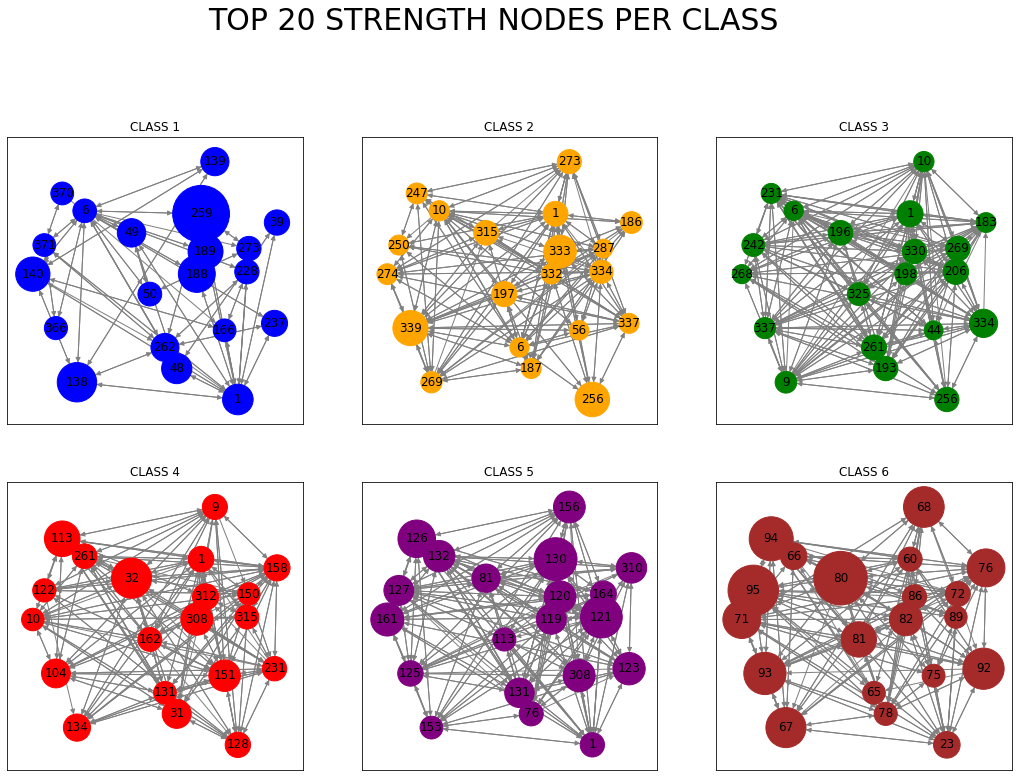

In [23]:
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown']
plt.figure(figsize=(18,18))
plt.suptitle('TOP 20 STRENGTH NODES PER CLASS', fontsize=30)
for c in range(len(G)):
  nodes = [nodes_strengths_sorted[c][i][0] for i in range(20)]

#controllare che le strength dei nodi siano abbinate ai nodi giusti

  subG = G[c].subgraph(nodes)
  nodes_strengths = [G[c].degree(n, weight='weight')*20e3 for n in subG.nodes] 
  pos = nx.random_layout(subG, seed=10)
  plt.subplot(3,3,c+1)
  nx.draw_networkx(subG, pos = pos, node_size=nodes_strengths, edgelist=list(filter(lambda x: x[0]!=x[1], subG.edges)), node_color=colors[c], edge_color='grey')
  plt.title('CLASS ' + str(c+1))

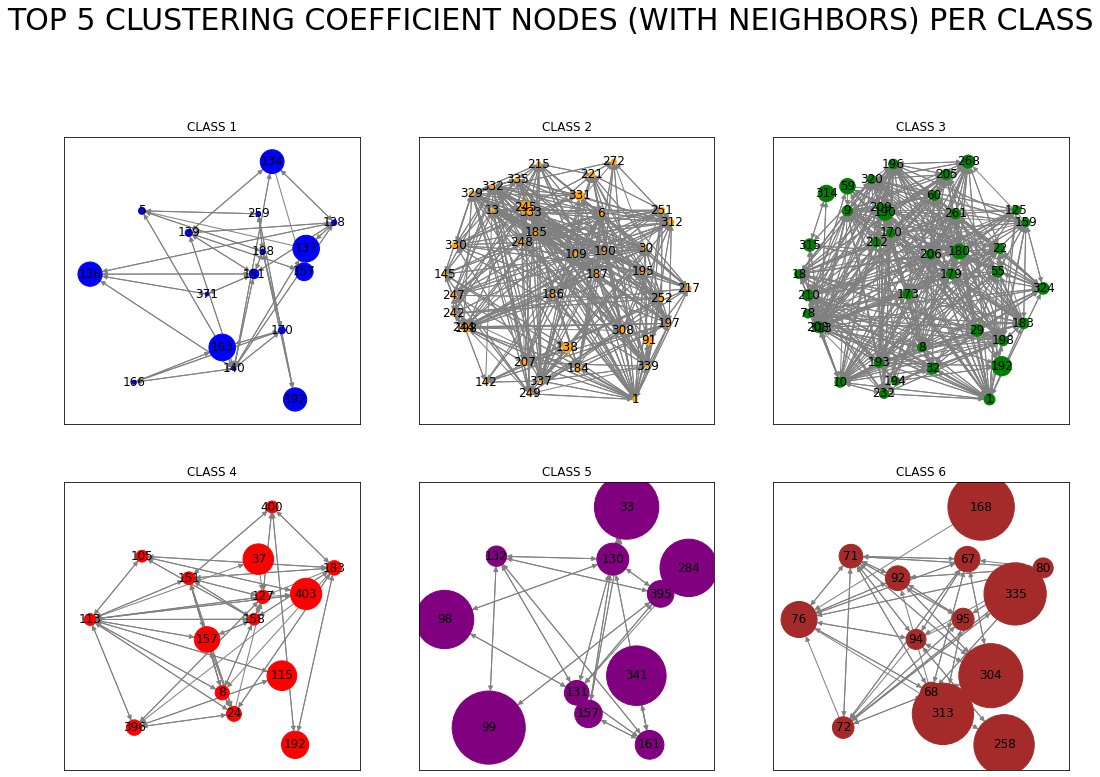

In [24]:
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown']
plt.figure(figsize=(18,18))
plt.suptitle('TOP 5 CLUSTERING COEFFICIENT NODES (WITH NEIGHBORS) PER CLASS', fontsize=30)
for c in range(len(G)):
  nodes = [cc_nodes_ordered[c][i][0] for i in range(5)]   #lista da cui si prednono i top 5
  nodes_with_nb = [list(G[c].neighbors(n)) for n in nodes]      #create a list of list with the neighbors of the top 5 node with highest clust coeff
  nodes_with_nb = [n for nb in nodes_with_nb for n in nb]      #form the list of lists, we create a single list
  nodes_with_nb.extend(nodes)
  nodes_with_nb = list(dict.fromkeys(nodes_with_nb))    #removing duplicates from list od nb                              #here we add the original 5 nodes, that are not considered in thei neighborhood
       
  subG = G[c].subgraph(nodes_with_nb)     
  nodes_size = [cc_nodes_all[c][n]*40e3 for n in subG.nodes]
  pos = nx.random_layout(subG, seed=10)
  plt.subplot(3,3,c+1)
  nx.draw_networkx(subG, pos = pos, node_size = nodes_size, edgelist=list(filter(lambda x: x[0]!=x[1], subG.edges)), node_color=colors[c], edge_color='grey')
  plt.title('CLASS ' + str(c+1))

### Temporal analysis

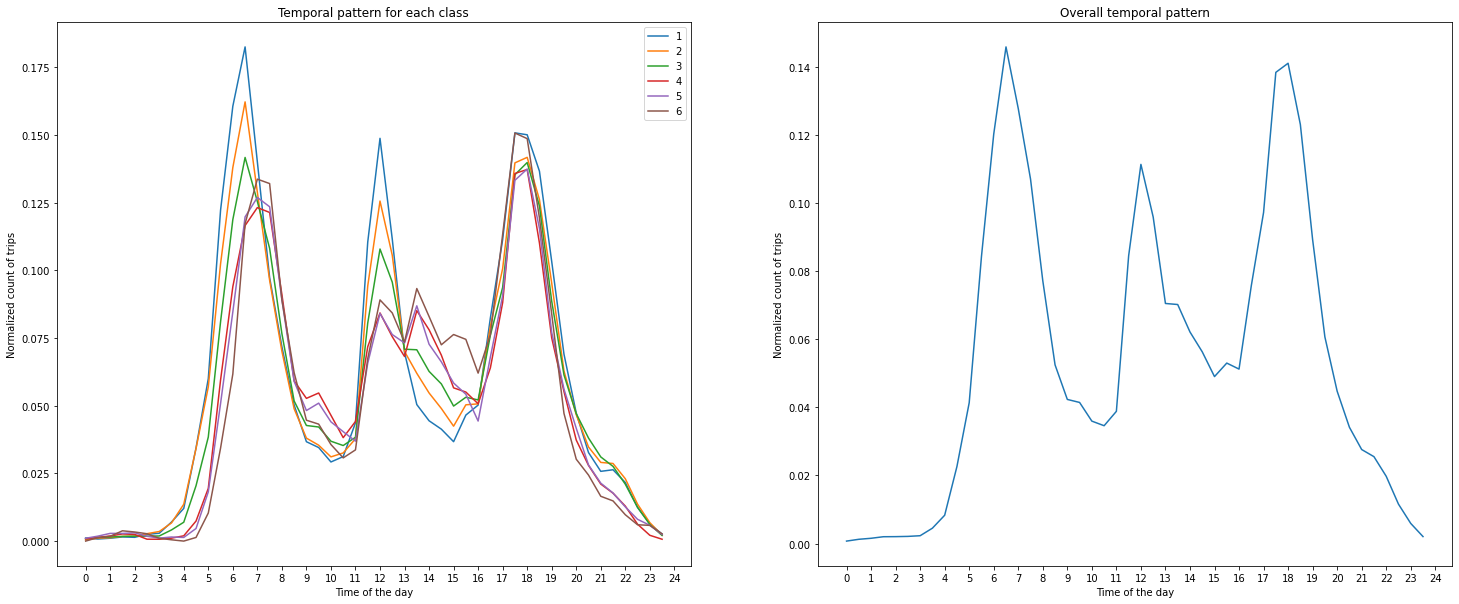

In [25]:
import matplotlib.pyplot as plt
percent_trips_class = [[0 for j in range(0,48)] for i in range(0,6)]
percent_trips_all = [0 for j in range(0,48)]
total_trips = [data.loc[data['EST'] == i+1]['FEV'].sum() for i in range(0,6)]
total_trips_all = data['FEV'].sum()

for t in range(48):
  hMin = (float)((t*30)/60);
  hMax = (float)(hMin + 0.50)
  percent_trips_all[t] = (float)((data.loc[(data['HLLEG'] >= hMin) & (data['HSAL'] <= hMax)])['FEV'].sum()) / total_trips_all
  for c in range(0,6):
   percent_trips_class[c][t] = ((float)(data.loc[(data['HLLEG'] >= hMin) & (data['HSAL'] <= hMax) & (data['EST'] == c+1)]['FEV'].sum())) / total_trips[c]

# hlleg arrivo 
# hsal partenza


x = [i*0.5 for i in range(0,48)]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))

for c in range(6):
  ax1.plot(x, percent_trips_class[c], label = str(c+1))

#ax1.xticks(np.arange(min(x), max(x)+1, 1.0))
ax1.title.set_text('Temporal pattern for each class')
ax1.set_xticks(range(0,25), minor=False)
ax1.set_ylabel('Normalized count of trips')
ax1.set_xlabel('Time of the day')
ax1.legend()

ax2.title.set_text('Overall temporal pattern')
ax2.plot(x, percent_trips_all)
ax2.set_xticks(range(0,25), minor=False)
ax2.set_ylabel('Normalized count of trips')
ax2.set_xlabel('Time of the day')
plt.show()

### Length of trip analysis
Distribution of trip length for the various classes

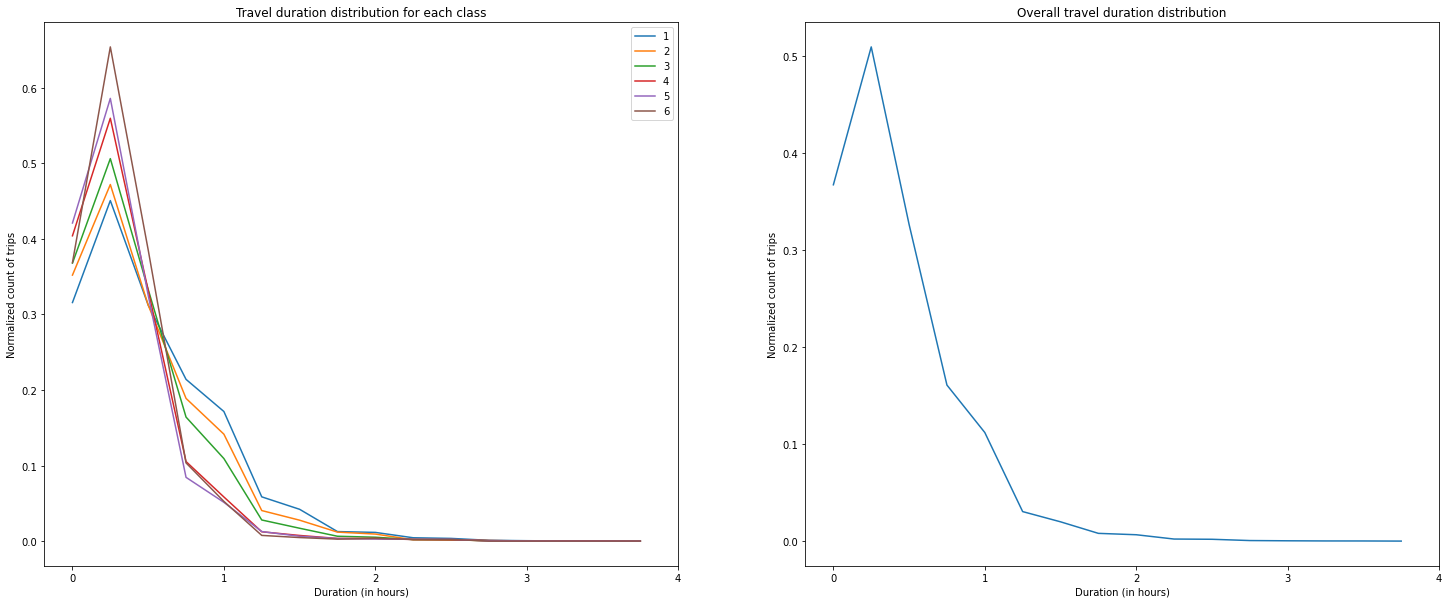

In [26]:
import matplotlib.pyplot as plt
max_duration = data['TIME'].max()  #max duration for a single trip across all dataset

percent_trips_class = [[0 for j in range(16)] for i in range(0,6)]
percent_trips_all = [0 for j in range(16)]

total_trips = [data.loc[data['EST'] == i+1]['FEV'].sum() for i in range(0,6)]
total_trips_all = data['FEV'].sum()

for t in range(16):
  hMin = (float)((t*0.25))
  hMax = (float)(hMin + 0.25)
  percent_trips_all[t] = (float)((data.loc[(data['TIME'] >= hMin) & (data['TIME'] <= hMax)])['FEV'].sum()) / total_trips_all
  for c in range(0,6):
   percent_trips_class[c][t] = ((float)(data.loc[(data['TIME'] >= hMin) & (data['TIME'] <= hMax) & (data['EST'] == c+1)]['FEV'].sum())) / total_trips[c]

# hlleg arrivo 
# hsal partenza


x = [i*0.25 for i in range(16)]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))

for c in range(6):
  ax1.plot(x, percent_trips_class[c], label = str(c+1))

#ax1.xticks(np.arange(min(x), max(x)+1, 1.0))
ax1.title.set_text('Travel duration distribution for each class')
ax1.set_xticks(range(5), minor=False)
ax1.set_ylabel('Normalized count of trips')
ax1.set_xlabel('Duration (in hours)')
ax1.legend()

ax2.title.set_text('Overall travel duration distribution')
ax2.plot(x, percent_trips_all)
ax2.set_xticks(range(5), minor=False)
ax2.set_ylabel('Normalized count of trips')
ax2.set_xlabel('Duration (in hours)')
plt.show()

In [27]:
mean_duration_list = list()
for i in range(6):
  mean_duration = data.loc[data['EST'] == i+1]['TIME'].mean()
  mean_duration_list.append(mean_duration)
  print('\nClass', i+1, '- mean travel duration across all trips:', mean_duration)



Class 1 - mean travel duration across all trips: 0.5679346386946387

Class 2 - mean travel duration across all trips: 0.5208814961576305

Class 3 - mean travel duration across all trips: 0.48580818459146236

Class 4 - mean travel duration across all trips: 0.4371701511428784

Class 5 - mean travel duration across all trips: 0.40400534943413835

Class 6 - mean travel duration across all trips: 0.4170878103001113
